In [2]:
#--------------------------imports--------------------------
import random
import math
import time
from cec2013.cec2013 import *
import numpy
import sys
import matplotlib.pyplot as plt
import susi
from susi.SOMPlots import plot_nbh_dist_weight_matrix, plot_umatrix

In [3]:
#-------------calculo de fitness para funcao esfera-------------

def fitness_01(position, dimension):
    fit = 0.0
    for dim in range(0, dimension):
        fit += pow(position[dim], 2)
    return fit

#--------------------definindo uma classe peixe--------------------
class fish:
    def __init__(self,dim):
        self.position = [0] * dim
        self.new_position = [0] *dim
        self.dif_distance = [0] * dim
        self.fitness = [0.0]
        self.dif_fitness = 0
        self.weight = 1
        self.follows = -1
        self.dist_normative = 0.0
        self.dist_expert = 0.0
        self.dist_theory = 0.0

In [4]:
# Não mexer nessa parte
from tespy.networks import network
from tespy.components import (
    turbine, splitter, merge, condenser, pump, sink, source,
    heat_exchanger_simple, desuperheater, cycle_closer
)
from tespy.connections import connection, bus
from tespy.tools import logger
import logging

import numpy as np


logger.define_logging(screen_level=logging.ERROR)


class PowerPlant():

    def __init__(self): # 'IF97::water'
        self.nw = network(
            fluids=['BICUBIC::water'],
            p_unit='bar', T_unit='C', h_unit='kJ / kg',
            iterinfo=False, memorise_fluid_properties=False)
        # components
        # main cycle
        eco = heat_exchanger_simple('economizer')
        eva = heat_exchanger_simple('evaporator')
        sup = heat_exchanger_simple('superheater')
        cc = cycle_closer('cycle closer')
        hpt = turbine('high pressure turbine')
        sp1 = splitter('splitter 1', num_out=2)
        mpt = turbine('mid pressure turbine')
        sp2 = splitter('splitter 2', num_out=2)
        lpt = turbine('low pressure turbine')
        con = condenser('condenser')
        pu1 = pump('feed water pump')
        fwh1 = condenser('feed water preheater 1')
        fwh2 = condenser('feed water preheater 2')
        dsh = desuperheater('desuperheater')
        me2 = merge('merge2', num_in=2)
        pu2 = pump('feed water pump 2')
        pu3 = pump('feed water pump 3')
        me = merge('merge', num_in=2)

        # cooling water
        cwi = source('cooling water source')
        cwo = sink('cooling water sink')

        # connections
        # main cycle
        cc_hpt = connection(cc, 'out1', hpt, 'in1', label='feed steam')
        hpt_sp1 = connection(hpt, 'out1', sp1, 'in1', label='extraction1')
        sp1_mpt = connection(sp1, 'out1', mpt, 'in1', state='g')
        mpt_sp2 = connection(mpt, 'out1', sp2, 'in1', label='extraction2')
        sp2_lpt = connection(sp2, 'out1', lpt, 'in1')
        lpt_con = connection(lpt, 'out1', con, 'in1')
        con_pu1 = connection(con, 'out1', pu1, 'in1')
        pu1_fwh1 = connection(pu1, 'out1', fwh1, 'in2')
        fwh1_me = connection(fwh1, 'out2', me, 'in1', state='l')
        me_fwh2 = connection(me, 'out1', fwh2, 'in2', state='l')
        fwh2_dsh = connection(fwh2, 'out2', dsh, 'in2', state='l')
        dsh_me2 = connection(dsh, 'out2', me2, 'in1')
        me2_eco = connection(me2, 'out1', eco, 'in1', state='l')
        eco_eva = connection(eco, 'out1', eva, 'in1')
        eva_sup = connection(eva, 'out1', sup, 'in1')
        sup_cc = connection(sup, 'out1', cc, 'in1')

        self.nw.add_conns(cc_hpt, hpt_sp1, sp1_mpt, mpt_sp2, sp2_lpt,
                          lpt_con, con_pu1, pu1_fwh1, fwh1_me, me_fwh2,
                          fwh2_dsh, dsh_me2, me2_eco, eco_eva, eva_sup, sup_cc)

        # cooling water
        cwi_con = connection(cwi, 'out1', con, 'in2')
        con_cwo = connection(con, 'out2', cwo, 'in1')

        self.nw.add_conns(cwi_con, con_cwo)

        # preheating
        sp1_dsh = connection(sp1, 'out2', dsh, 'in1')
        dsh_fwh2 = connection(dsh, 'out1', fwh2, 'in1')
        fwh2_pu2 = connection(fwh2, 'out1', pu2, 'in1')
        pu2_me2 = connection(pu2, 'out1', me2, 'in2')

        sp2_fwh1 = connection(sp2, 'out2', fwh1, 'in1')
        fwh1_pu3 = connection(fwh1, 'out1', pu3, 'in1')
        pu3_me = connection(pu3, 'out1', me, 'in2')

        self.nw.add_conns(sp1_dsh, dsh_fwh2, fwh2_pu2, pu2_me2,
                          sp2_fwh1, fwh1_pu3, pu3_me)

        # busses
        # power bus
        self.power = bus('power')
        self.power.add_comps(
            {'comp': hpt, 'char': -1}, {'comp': mpt, 'char': -1},
            {'comp': lpt, 'char': -1}, {'comp': pu1, 'char': -1},
            {'comp': pu2, 'char': -1}, {'comp': pu3, 'char': -1})

        # heating bus
        self.heat = bus('heat')
        self.heat.add_comps(
            {'comp': eco, 'char': 1}, {'comp': eva, 'char': 1},
            {'comp': sup, 'char': 1})

        self.nw.add_busses(self.power, self.heat)

        # parametrization
        # components
        hpt.set_attr(eta_s=0.9)
        mpt.set_attr(eta_s=0.9)
        lpt.set_attr(eta_s=0.9)

        pu1.set_attr(eta_s=0.8)
        pu2.set_attr(eta_s=0.8)
        pu3.set_attr(eta_s=0.8)

        eco.set_attr(pr=0.99)
        eva.set_attr(pr=0.99)
        sup.set_attr(pr=0.99)

        con.set_attr(pr1=0.99, pr2=0.99, ttd_u=5)
        fwh1.set_attr(pr1=0.99, pr2=0.99, ttd_u=5)
        fwh2.set_attr(pr1=0.99, pr2=0.99, ttd_u=5)
        dsh.set_attr(pr1=0.99, pr2=0.99)

        # connections
        eco_eva.set_attr(x=0)
        eva_sup.set_attr(x=1)

        cc_hpt.set_attr(m=200, T=650, p=100, fluid={'water': 1})
        hpt_sp1.set_attr(p=20)
        mpt_sp2.set_attr(p=3)
        lpt_con.set_attr(p=0.05)

        cwi_con.set_attr(T=20, p=10, fluid={'water': 1})

    def calculate_efficiency(self, x):
        # set extraction pressure
        self.nw.connections['extraction1'].set_attr(p=x[0])
        self.nw.connections['extraction2'].set_attr(p=x[1])

        self.nw.solve('design')

        for cp in self.nw.components.values():
            if isinstance(cp, condenser) or isinstance(cp, desuperheater):
                if cp.Q.val > 0:
                    return np.nan
            elif isinstance(cp, pump):
                if cp.P.val < 0:
                    return np.nan
            elif isinstance(cp, turbine):
                if cp.P.val > 0:
                    return np.nan

        if self.nw.res[-1] > 1e-3 or self.nw.lin_dep:
         #   return np.nan
            return self.nw.busses['power'].P.val / self.nw.busses['heat'].P.val
        else:
            return self.nw.busses['power'].P.val / self.nw.busses['heat'].P.val

In [5]:
# Não mexer nessa parte, só precisa mudar a função "def fitness(self, x):" quando necessário

import math
class optimization_problem():

    def fitness(self, x):
        #f1 = 1/self.model.calculate_efficiency(x) # problema de minimização
        f1 = self.model.calculate_efficiency(x) # problema de maximização
        if math.isnan(f1): # se encontrar um valor impossível, põe a pior eficiência
            #f1 = 10.0 #  minimizar
            f1 = 0.0 #  maximizar
        return f1

    def get_nobj(self):
        """Return number of objectives."""
        return 1

    # equality constraints
    def get_nec(self):
        return 0

    # inequality constraints
    def get_nic(self):
        return 1

    def get_bounds(self):
        """Return bounds of decision variables."""
        return ([1, 1], [100, 100])
    
optimize = optimization_problem()
optimize.model = PowerPlant()

In [6]:
#Função de check das constraints - Retorna TRUE se todas as constraints forem satisfeitas ou FALSE se alguma não for
#Formato da constraint - array:
#Posição 0 - Inteiro - Número da dimensão à esquerda da comparação
#Posição 1 - String - Operador de comparação
#Posição 2 - Inteiro - Número da dimensão à direita da comparação
#Posição 3 - Float - Multiplicador da comparação
#Posição 4 - Float - Somador da comparação

#Exemplos:
#[0,">",1,0.5,1.3] ==> Posição[0] > Posição[1] * 0.5 + 1.3
#[0,"<=",1,1.0,0.0] ==> Posição[0] <= Posição[1] * 1.0 + 0.0 ==> Posição[0] <= Posição[1]
#[0,"<>",1,0.0,2.0] ==> Posição[0] <> Posição[1] * 0.0 + 2.0 ==> Posição[0] <> 2.0
def check_constraints(constraints, position):
    check = True
    for constraint in constraints:
        if constraint[1] == "=":
            if not(position[constraint[0]] == position[constraint[2]] * constraint[3] + constraint[4]):
                check = False
                break
        elif constraint[1] == "<>":
            if not(position[constraint[0]] != position[constraint[2]] * constraint[3] + constraint[4]):
                check = False
                break
        elif constraint[1] == "<=":
            if not(position[constraint[0]] <= position[constraint[2]] * constraint[3] + constraint[4]):
                check = False
                break
        elif constraint[1] == "<":
            if not(position[constraint[0]] < position[constraint[2]] * constraint[3] + constraint[4]):
                check = False
                break
        elif constraint[1] == ">=":
            if not(position[constraint[0]] >= position[constraint[2]] * constraint[3] + constraint[4]):
                check = False
                break
        elif constraint[1] == ">":
            if not(position[constraint[0]] > position[constraint[2]] * constraint[3] + constraint[4]):
                check = False
                break
        else:
            check = False
            break
    return check
    

In [7]:
#--------------------Movimento individual Cultural (verificação de constraints)--------------------
def individual_Movement_Cultural(nFish, dimension, fishes, upper_Limit, lower_Limit, step, function, prop, finalStep, constraints):
    new_fitness = []
    direction = [-1, 1]
    for fish in range(0, nFish):
              
        for dim in range(0, dimension):
            #calcula a nova posição
            move = random.choice(direction)*step*(upper_Limit[dim] - lower_Limit[dim])
            fishes[fish].new_position[dim] = fishes[fish].position[dim] + move
            #verifica se ultrapassa os limites superior e inferior
            if fishes[fish].new_position[dim] > upper_Limit[dim]:
                fishes[fish].new_position[dim] = upper_Limit[dim]
            elif fishes[fish].new_position[dim] < lower_Limit[dim]:
                fishes[fish].new_position[dim] = lower_Limit[dim]
        
        #Checa se as constraints são satisfeitas. Se sim, calcula fitness da nova posição. Se não, considera fitness = 0
        if check_constraints(constraints, fishes[fish].new_position):
            #verifica o fitness da nova posicao
            if function == 0: #Função Esfera
                new_fitness.append(fitness_01(fishes[fish].new_position, dimension))
            elif function == 99: #Tespy
                print("Peixe: "+ str(fish) +" Posição: " +  str(fishes[fish].new_position)) #individual
                new_fitness.append(optimize.fitness(fishes[fish].new_position))
                print("Fitness: " + str(fishes[fish].fitness[0]))
            else:
                a = CEC2013(function)
                fit = a.evaluate(fishes[fish].new_position)
                if isinstance(fit, list):
                    new_fitness.append(fit[0])
                elif isinstance(fit, float):
                    new_fitness.append(fit)
                elif isinstance(fit, numpy.ndarray):
                    new_fitness.append(fit[0])
                elif isinstance(fit, numpy.int64):
                    new_fitness.append(fit)
                else:
                    print("erro passo ind", type(fit))
        else:
            new_fitness.append(0.0)
            
        #Verifica se houve ganho de fitness para decidir se atualiza a posição ou mantém a anterior
        if(new_fitness[fish] > fishes[fish].fitness[0]):
            fishes[fish].dif_fitness = new_fitness[fish] - fishes[fish].fitness[0]
            fishes[fish].fitness[0] = new_fitness[fish]
            for dim in range(0, dimension):
                fishes[fish].dif_distance[dim] = fishes[fish].new_position[dim] - fishes[fish].position[dim]
                fishes[fish].position[dim] = fishes[fish].new_position[dim]
        else:
            fishes[fish].dif_fitness = 0
            for dim in range(0, dimension):
                fishes[fish].dif_distance[dim] = 0

In [8]:
#--------------------Movimento individual--------------------
def individual_Movement(nFish, dimension, fishes, upper_Limit, lower_Limit, step, function, prop, finalStep):
    new_fitness = []
    direction = [-1, 1]
    for fish in range(0, nFish):
              
        for dim in range(0, dimension):
            #calcula a nova posição
            move = random.choice(direction)*step*(upper_Limit[dim] - lower_Limit[dim])
            fishes[fish].new_position[dim] = fishes[fish].position[dim] + move
            #verifica se ultrapassa os limites superior e inferior
            if fishes[fish].new_position[dim] > upper_Limit[dim]:
                fishes[fish].new_position[dim] = upper_Limit[dim]
            elif fishes[fish].new_position[dim] < lower_Limit[dim]:
                fishes[fish].new_position[dim] = lower_Limit[dim]
            
        #verifica o fitness da nova posicao
        if function == 0: #Função Esfera
            new_fitness.append(fitness_01(fishes[fish].new_position, dimension))
        elif function == 99: #Tespy
            new_fitness.append(optimize.fitness(fishes[fish].new_position))
        else:
            a = CEC2013(function)
            fit = a.evaluate(fishes[fish].new_position)
            if isinstance(fit, list):
                new_fitness.append(fit[0])
            elif isinstance(fit, float):
                new_fitness.append(fit)
            elif isinstance(fit, numpy.ndarray):
                new_fitness.append(fit[0])
            elif isinstance(fit, numpy.int64):
                new_fitness.append(fit)
            else:
                print("erro passo ind", type(fit))
        
        #Verifica se houve ganho de fitness para decidir se atualiza a posição ou mantém a anterior
        if(new_fitness[fish] > fishes[fish].fitness[0]):
            fishes[fish].dif_fitness = new_fitness[fish] - fishes[fish].fitness[0]
            fishes[fish].fitness[0] = new_fitness[fish]
            for dim in range(0, dimension):
                fishes[fish].dif_distance[dim] = fishes[fish].new_position[dim] - fishes[fish].position[dim]
                fishes[fish].position[dim] = fishes[fish].new_position[dim]
        else:
            fishes[fish].dif_fitness = 0
            for dim in range(0, dimension):
                fishes[fish].dif_distance[dim] = 0

In [9]:
#--------------------Distancia entre 2 peixes------------------
def distance(fishA, fishB, dimension):
    dist = 0
    for i in range(0, dimension):
        dist += pow(fishA.position[i] - fishB.position[i], 2)
    return math.sqrt(dist)

#--------------------Distancia NORMALIZADA entre 2 peixes------------------
def distanceNormal(fishA, fishB, fishes, dimension, upper_Limit):
    dist = 0
    for i in range(0, dimension):
        dist += pow(fishes[fishA].position[i]/upper_Limit[i] - fishes[fishB].position[i]/upper_Limit[i], 2)
    return math.sqrt(dist/dimension)

#--------------------Distância para limites do algoritmo cultural------------------
#Verifica a menor distância de cada dimensão da posição do peixe para o limite do domínio de conhecimento
def distance_cultural(position, dimension, lower_limit, upper_limit):
    dist = 0
    for i in range(0, dimension):
        gap = upper_limit[i] - lower_limit[i]
        if (position[i] - lower_limit[i]) < (upper_limit[i] - position[i]):
            dist += (position[i] - lower_limit[i])/ gap
        else:
            dist += (upper_limit[i] - position[i])/ gap
    return dist

#--------------------Normalização da distância para limites do algoritmo cultural------------------
def norm_dist_cultural(dist, dist_min, dist_max, mult_min, mult_max):
    multiplicador = (dist - dist_min) * (mult_max - mult_min) / (dist_max - dist_min) + mult_min
    return multiplicador

#--------------------Feeding do algoritmo cultural------------------
def feeding_cultural(nfish, fishes, dimension, lower_limit_normative, upper_limit_normative, lower_limit_expert, upper_limit_expert, lower_limit_theory, upper_limit_theory):
    max_dif = 0.0
    for i in range (0, nfish):
        if fishes[i].dif_fitness>max_dif:
            max_dif = fishes[i].dif_fitness
        #Calcula a menor distância de cada dimensão das posições dos peixes para os limites do domínio de conhecimento
        fishes[i].dist_normative = distance_cultural(fishes[i].position, dimension, lower_limit_normative, upper_limit_normative)
        fishes[i].dist_expert = distance_cultural(fishes[i].position, dimension, lower_limit_expert, upper_limit_expert)
        fishes[i].dist_theory = distance_cultural(fishes[i].position, dimension, lower_limit_theory, upper_limit_theory)
        #Verifica as distâncias mínimas e máximas
        if i == 0:
            min_dist_normative = fishes[i].dist_normative
            min_dist_expert = fishes[i].dist_expert
            min_dist_theory = fishes[i].dist_theory
            max_dist_normative = fishes[i].dist_normative
            max_dist_expert = fishes[i].dist_expert
            max_dist_theory = fishes[i].dist_theory
        else:
            if fishes[i].dist_normative < min_dist_normative:
                min_dist_normative = fishes[i].dist_normative
            if fishes[i].dist_expert < min_dist_expert:
                min_dist_expert = fishes[i].dist_expert
            if fishes[i].dist_theory < min_dist_theory:
                min_dist_theory = fishes[i].dist_theory
            if fishes[i].dist_normative > max_dist_normative:
                max_dist_normative = fishes[i].dist_normative
            if fishes[i].dist_expert > max_dist_expert:
                max_dist_expert = fishes[i].dist_expert
            if fishes[i].dist_theory > max_dist_theory:
                max_dist_theory = fishes[i].dist_theory
    if max_dif != 0:
        for i in range (0, nfish):
            #Calcula so multiplicadores do domínio do conhecimento através da normalização da distância de cada dimensão da posição do peixe para o limite do domínio de conhecimento 
            #Normative - Entre 0 e 1 (Penaliza adição de peso para peixes próximos do limite das normas)
            mult_normative = norm_dist_cultural(fishes[i].dist_normative, min_dist_normative, max_dist_normative, 0, 1)
            #Expert - Entre 1 e 2 (Recompensa adição de peso para peixes distantes do limite do especialista)
            mult_expert = norm_dist_cultural(fishes[i].dist_expert, min_dist_expert, max_dist_expert, 1, 2)
            #Theory - Entre 1 e 2 (Recompensa adição de peso para peixes distantes do limite do conhecimento teórico)
            mult_theory = norm_dist_cultural(fishes[i].dist_theory, min_dist_theory, max_dist_theory, 1, 2)
            fishes[i].weight += (fishes[i].dif_fitness/max_dif) * mult_normative * mult_expert * mult_theory

#--------------------Feeding--------------------
def feeding(nfish, fishes):
    max_dif = 0.0
    for i in range (0, nfish):
        if fishes[i].dif_fitness>max_dif:
            max_dif = fishes[i].dif_fitness
    if max_dif != 0:
        for i in range (0, nfish):
            fishes[i].weight += fishes[i].dif_fitness/max_dif
            
#-------------Calcula peso do cardume------------
def total_Weight(fishes, nfish):
    new_weight = 0
    for i in range (0, nfish):
        new_weight += fishes[i].weight
    return new_weight

In [10]:
#-----------------------Followers----------------------
def followers(nfish, fishes):
    for a in range(0, nfish):
        b = random.randint(0, nfish-1)
        if (fishes[a].follows != -1):
            aux = fishes[a].follows
            if (fishes[aux].weight < fishes[a].weight):
                fishes[a].follows = -1
                if (fishes[b].weight > fishes[a].weight):
                    fishes[a].follows = b
            else:
                sumA = 0
                sumB = 0
                for i in range(0, nfish):
                    if (fishes[i].follows == a):
                        sumA += fishes[i].weight
                    elif (fishes[i].follows == b):
                        sumB += fishes[i].weight
                if (sumA > sumB):
                    fishes[a].follows = b
        elif (fishes[b].weight > fishes[a].weight):
            fishes[a].follows = b

In [11]:
#--------------------Movimento instintivo--------------------
def individual_Instintivo_Cultural(iteration, maxIteration, fishes, nfish, dimension, upper_Limit, lower_Limit, constraints):
    alpha = iteration/maxIteration
    for i in range (0, nfish):
        if (fishes[i].follows != -1):
            L = 0
            l = 0
        else:
            L = 1
            l = fishes[i].follows
            for j in range (0, dimension):
                if ((fishes[i].dif_fitness + L*fishes[l].dif_fitness) != 0):
                    fishes[i].new_position[j] += alpha*(fishes[i].dif_distance[j]*fishes[i].dif_fitness + L*fishes[l].dif_distance[j]*fishes[l].dif_fitness)/(fishes[i].dif_fitness + L*fishes[l].dif_fitness)
                    #verifica se ultrapassa os limites superior e inferior
                    if fishes[i].new_position[j] > upper_Limit[j]:
                        fishes[i].new_position[j] = upper_Limit[j]
                    elif fishes[i].new_position[j] < lower_Limit[j]:
                        fishes[i].new_position[j] = lower_Limit[j]
                    #Checa se as constraints são satisfeitas. Se sim, atualiza posição. Se não, mantém posição anterior
                    if check_constraints(constraints, fishes[i].new_position):
                        fishes[i].position = fishes[i].new_position

In [12]:
#--------------------Movimento instintivo--------------------
def individual_Instintivo(iteration, maxIteration, fishes, nfish, dimension, upper_Limit, lower_Limit):
    alpha = iteration/maxIteration
    for i in range (0, nfish):
        if (fishes[i].follows != -1):
            L = 0
            l = 0
        else:
            L = 1
            l = fishes[i].follows
            for j in range (0, dimension):
                if ((fishes[i].dif_fitness + L*fishes[l].dif_fitness) != 0):
                    fishes[i].position[j] += alpha*(fishes[i].dif_distance[j]*fishes[i].dif_fitness + L*fishes[l].dif_distance[j]*fishes[l].dif_fitness)/(fishes[i].dif_fitness + L*fishes[l].dif_fitness)
                    #verifica se ultrapassa os limites superior e inferior
                    if fishes[i].position[j] > upper_Limit[j]:
                        fishes[i].position[j] = upper_Limit[j]
                    elif fishes[i].position[j] < lower_Limit[j]:
                        fishes[i].position[j] = lower_Limit[j]

In [13]:
#-----------atualizar passo-----------------
def attStep(step, inicialStep, finalStep, maxIteration):
    return step - ((inicialStep - finalStep)/ maxIteration)
    

In [14]:
#--------------------Movimento volitivo--------------------
def individual_Volitivo_Cultural(nfish, dimension, dif_Weight, step,upper_Limit, lower_Limit, fishes, prop, finalStep, constraints):
    baricentro = fish(dimension)
    step_vol = step
    
    for i in range (0, nfish):
        if (fishes[i].follows == -1):
            L = 0
            l = 0
        else:
            L = 1
            l = fishes[i].follows
        if (L!=0):
            for j in range (0, dimension):
                baricentro.position[j] = (fishes[i].position[j]*fishes[i].weight + L*fishes[l].position[j]*fishes[l].weight)/(fishes[i].weight + L*fishes[l].weight)
            for j in range (0, dimension):
                if (distance(fishes[i], baricentro, dimension) != 0):
                    if (dif_Weight > 0):
                        fishes[i].new_position[j] -= step_vol*(upper_Limit[j]-lower_Limit[j])*random.random()*(fishes[i].position[j] - baricentro.position[j])/(distance(fishes[i], baricentro, dimension))
                    else:
                        fishes[i].new_position[j] += step_vol*(upper_Limit[j]-lower_Limit[j])*random.random()*(fishes[i].position[j] - baricentro.position[j])/(distance(fishes[i], baricentro, dimension))
                    #verifica se ultrapassa os limites superior e inferior
                    if fishes[i].new_position[j] > upper_Limit[j]:
                        fishes[i].new_position[j] = upper_Limit[j]
                    elif fishes[i].new_position[j] < lower_Limit[j]:
                        fishes[i].new_position[j] = lower_Limit[j]
                    #Checa se as constraints são satisfeitas. Se sim, atualiza posição. Se não, mantém posição anterior
                    if check_constraints(constraints, fishes[i].new_position):
                        fishes[i].position = fishes[i].new_position

In [15]:
#--------------------Movimento volitivo--------------------
def individual_Volitivo(nfish, dimension, dif_Weight, step,upper_Limit, lower_Limit, fishes, prop, finalStep):
    baricentro = fish(dimension)
    step_vol = step
    
    for i in range (0, nfish):
        if (fishes[i].follows == -1):
            L = 0
            l = 0
        else:
            L = 1
            l = fishes[i].follows
        if (L!=0):
            for j in range (0, dimension):
                baricentro.position[j] = (fishes[i].position[j]*fishes[i].weight + L*fishes[l].position[j]*fishes[l].weight)/(fishes[i].weight + L*fishes[l].weight)
            for j in range (0, dimension):
                if (distance(fishes[i], baricentro, dimension) != 0):
                    if (dif_Weight > 0):
                        fishes[i].position[j] -= step_vol*(upper_Limit[j]-lower_Limit[j])*random.random()*(fishes[i].position[j] - baricentro.position[j])/(distance(fishes[i], baricentro, dimension))
                    else:
                        fishes[i].position[j] += step_vol*(upper_Limit[j]-lower_Limit[j])*random.random()*(fishes[i].position[j] - baricentro.position[j])/(distance(fishes[i], baricentro, dimension))
                #verifica se ultrapassa os limites superior e inferior
                if fishes[i].position[j] > upper_Limit[j]:
                    fishes[i].position[j] = upper_Limit[j]
                elif fishes[i].position[j] < lower_Limit[j]:
                    fishes[i].position[j] = lower_Limit[j]
                

In [16]:
#-----------------------------Quick sort-----------------------------
def troca(list_fish, list_weight, i, j):
    aux = list_weight[i]
    list_weight[i] = list_weight[j]
    list_weight[j] = aux
    aux = list_fish[i]
    list_fish[i] = list_fish[j]
    list_fish[j] = aux


def particiona( list_fish, list_weight,  inicio,  fim,  minMax):
    pivo = list_weight[fim];
    pivo_indice = inicio;

    for i in range (inicio, fim):
        if(minMax==0): # para colocar do maior para o menor = 0, CC /=1
            if(list_weight[i] >= pivo):
                troca(list_fish, list_weight, i, pivo_indice)
                pivo_indice += 1
            
        else:
            if(list_weight[i] <= pivo):
                troca(list_fish, list_weight, i, pivo_indice)
                pivo_indice += 1

    troca(list_fish, list_weight, pivo_indice, fim);
    return pivo_indice;

#---Vai receber uma lista de peixes e uma de pesos e 
#---vai retornar uma lista com os peixes ordenados de acordo com seu peso
#-------O minMax define se a ordenação vai ser crescente ou decrescente--------
def quick_Sort(list_fish, list_weight, inicio,  fim,  minMax): 
    if(inicio < fim):
        pivo_indice = particiona(list_fish, list_weight, inicio, fim, minMax)
        quick_Sort(list_fish, list_weight, inicio, pivo_indice - 1, minMax)
        quick_Sort(list_fish, list_weight, pivo_indice + 1, fim, minMax)


In [17]:
#----------Definição dos subSwarms para problemas com multiplos pontos de otimo--------------
#----------VERIFICAR SE ESTA CORRETO----------------------
#def subSwarms(fishes, nfish, dimension, paramD, upper_Limit):
#    list_weight = []
#    list_fish = []
#    
#    for i in range (0, nfish):
#        list_fish.append(i)
#        list_weight.append(fishes[i].fitness) # comentar sobre isso no artigo
#        
#    quick_Sort(list_fish, list_weight, 0,  nfish-1,  0)
#    
#    for i in range(0, len(list_fish)):
#        for j in range(i+1, len(list_fish)):
#            if j < len(list_fish):
#                dist = distanceNormal(list_fish[i], list_fish[j], fishes, dimension, upper_Limit)
#                if (dist < paramD):
#                    list_fish.remove(list_fish[j])
#    return list_fish


def subSwarms(fishes, nfish, dimension, paramD, upper_Limit):
    list_weight = []
    list_fish = []
    list_coordinates = []
    
    for i in range (0, nfish):
        list_fish.append(i)
        list_weight.append(fishes[i].fitness) # comentar sobre isso no artigo
        fish_coordinates = []
        for j in range (0, dimension):
            fish_coordinates.append(fishes[i].position[j])
        list_coordinates.append(fish_coordinates)
    print(list_coordinates)
        
    quick_Sort(list_fish, list_weight, 0,  nfish-1,  0)
    
    for i in range(0, len(list_fish)):
        for j in range(i+1, len(list_fish)):
            if j < len(list_fish):
                dist = distanceNormal(list_fish[i], list_fish[j], fishes, dimension, upper_Limit)
                if (dist < paramD):
                    list_fish.remove(list_fish[j])
    return list_fish


   
    
# Conhecimento Topográfico
#def subSwarms_cult(fishes, nfish, dimension, paramD, upper_Limit):
#    list_weight = []
#    list_fish = []
#    
#    for i in range (0, nfish):
#        list_fish.append(i)
#        list_weight.append(fishes[i].fitness) # comentar sobre isso no artigo
#        
#    for i in range(0, dimension):
#        fishes[fishA].position[i]
#    return

In [18]:
#------definindo os valores de upper e lower limit e das dimensoes de acordo com a funcao usada-------
def defFuncValues(upper_Limit, lower_Limit, dimension, func):
    
    if func == 0: #Função esfera
        for i in range (0, 30):
            upper_Limit.append(100)
            lower_Limit.append(-100)
        dimension[0] = 30
    elif func == 99: #Tespy
        dimension[0] = 2
        low_Lim,up_Lim = optimize.get_bounds()
        for i in range (0, dimension[0]):
            upper_Limit.append(up_Lim[i])
            lower_Limit.append(low_Lim[i])
    else:
        f = CEC2013(func)
        dimension[0] = f.get_dimension()
        for i in range (0, dimension[0]):
            upper_Limit.append(f.get_ubound(i))
            lower_Limit.append(f.get_lbound(i))

In [19]:
#-------calculando o fitness de todos os peixes------------------
def fitnessGeral(nfish, fishes, func, dimension):
    for j in range (0, nfish):
        if func == 0: #Função esfera
            fishes[j].fitness[0] = fitness_01(fishes[j].position, dimension[0])
        elif func == 99: #Tespy
            print("Peixe: "+ str(j) +" Posição: " +  str(fishes[j].position))
            fishes[j].fitness[0] = optimize.fitness(fishes[j].position) # geral
            print("Fitness: " + str(fishes[j].fitness[0]))
        else:
            a = CEC2013(func)
            fit = a.evaluate(fishes[j].position)
            if isinstance(fit, list):
                fishes[j].fitness[0] = fit[0]
            elif isinstance(fit, float):
                fishes[j].fitness[0] = fit
            elif isinstance(fit, numpy.ndarray):
                fishes[j].fitness[0] = fit[0]
            elif isinstance(fit, numpy.int64):
                fishes[j].fitness[0] = fit
            else:
                print("erro passo ind", type(fit))
                        
                                                
##-------------- distancia entre 2 pontos-------------------
#def distTwoPoint(posA, posB, dimension):
#    dist = 0
#    for i in range(0, dimension):
#        dist += pow(posA[i] - posB[i], 2)
#    return math.sqrt(dist)   
#
##------------- Calculando o numero de pontos de otimo unicos--------------
#def uniqOtimPoint(nicheRadius, func, position, nOP, dimension):
#    n = nOP
#    minDist = nicheRadius[func-1]
#    for i in range(0, n):
#        for j in range (i+1, n):
#            if(distTwoPoint(position[i], position[j], dimension)<minDist):
#                del(position[j])
#                j -=1
#                n -=1
#    return position

In [20]:
#-------------------------avaliando resultados-------------------------
def avalResult(fishes, nfish, dimension, paramD, upper_Limit, func, precisao, nOtimPoint):
    
    result1 = 0.0
    result2 = 0.0    
    subSwarm = subSwarms(fishes, nfish, dimension[0], paramD, upper_Limit)
    if ((func > 0) and (func<99)):
        f = CEC2013(func)
        fitnessFinal = np.zeros( (len(subSwarm), dimension[0]) )

        for i in range(0, len(subSwarm)):
            fitnessFinal[i] = fishes[subSwarm[i]].position
        count,seeds = how_many_goptima(fitnessFinal, f, precisao)
        criterio1 = count/nOtimPoint[func-1]
        result1 += criterio1
        criterio2 = (count/len(subSwarm)) * criterio1
        result2 += criterio2
        print("Resultado: ", func, ": ","%.2f" %  criterio1, " ", "%.2f" % criterio2)
        print("numero de peixes retornados: ", len(subSwarm), "Peixes corretos:", count, "posição:", seeds)
        #print(uniqOtimPoint(nicheRadius, func, seeds, len(seeds), dimension[0]))
    else:
        result1 = 0
        result2 = 0
    return [result1, result2, subSwarm]

In [22]:
#-------------------------inicialização-------------------------
    
def main(func, inicialStep, finalStep, paramD, nfish, precisao, ajustePasso, iterations, 
         lower_limit_normative, upper_limit_normative, lower_limit_expert, upper_limit_expert, 
         lower_limit_theory, upper_limit_theory, limit_history, constraints, modo_temporal):
    
    #inicialStep = 0.0599
    #finalStep = 0.0000001
    #paramD = 0.0001
    #nfish = 69
    # numero de pontos de otimo em cada função:
    nOtimPoint = [2,5,1,4,2,18,36,81, 216, 12, 6, 8, 6, 6, 8, 6, 8, 6, 8, 8]
    # Raio para diferenciar soluções:
    nicheRadius = [0.01, 0.01, 0.01, 0.01, 0.5, 0.5, 0.2, 0.5, 0.2, 0.01] 
    nicheRadius.extend([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,0.01])
    
    #-----------inicializando variaveis e definindo limtes/dimensões----------------
    result3 = 0
    tempo = 0
    #iterations = 10 #int(25000/nfish)
    upper_Limit = []
    lower_Limit = []
    dimension = [0]
    defFuncValues(upper_Limit, lower_Limit, dimension, func)
    
    #----------diferentes funções tem diferentes limites de aval. de fitness-------------
    if (func>5) and (func<99) and (dimension[0] ==2):
        nfish *= 2
        iterations *= 2
    elif(func>6) and (func<99) and (dimension[0]>2):
        nfish *= 2;
        iterations *= 4

    begin = time.time()
    fishes = []
    step = inicialStep
    best = 0
    steps_not_improving = 0

    #------iniciando os peixes em posições aleatorias no espaco de busca-----
    for i in range (0, nfish):
        fishes.append(fish(dimension[0]))
        check_constraint = False
        while not(check_constraint):
            for j in range (0, dimension[0]):
                fishes[i].position[j] = random.random()*(upper_Limit[j]-lower_Limit[j]) + lower_Limit[j]
                if fishes[i].position[j] > upper_Limit[j]:
                    fishes[i].position[j] = upper_Limit[j]
                elif fishes[i].position[j] < lower_Limit[j]:
                    fishes[i].position[j] = lower_Limit[j]
            #Checa se as constraints são satisfeitas. Se sim, usa essa posição. Se não, gera uma nova posição aleatória 
            check_constraint = check_constraints(constraints, fishes[i].position)
            
    last_weight = total_Weight(fishes, nfish)
    
    fitnessGeral(nfish, fishes, func, dimension) 
    
    #----------imprimir as posiões para fazer visualização com o SDL2-----------------
    #with open('gerarVisualizacao/posicoes' + str(func) + '.txt', 'w') as wrt:
        #----------imprimir as posiões para fazer visualização com o SDL2-----------------
        #with open('gerarVisualizacao/links' + str(func) + '.txt', 'w') as wlink:
    
    i = 0 # Modificado para conhecimento temporal
    iterations_init = iterations # Modificado para conhecimento temporal, guarda o número incial de iterações
    best_sum = 0 # Modificado para conhecimento temporal
    steps_not_improving = 0 # Modificado para conhecimento temporal
    while (i < iterations): # Modificado para conhecimento temporal   "for i in range (0, iterations):"
  
    #------------escrevendo follows num txt(apenas para 1 e 2 Dim------------
    #if (dimension[0] < 3):
    #    pos = ""
    #    link = ""
    #    for j in range (0, nfish):
    #        for m in range (0, len(fishes[j].follows)):
    #            link+=str(fishes[j].follows[m]) + "\\"
    #        link += "\n"
    #        for k in range (0, dimension[0]):
    #            pos += str(fishes[j].position[k]) + "\n"
    #    wlink.write(link)
    #    wrt.write(pos)
        print(str(i*100/iterations) + '%                             ', end='\r')
        individual_Movement_Cultural(nfish, dimension[0], fishes, upper_Limit,lower_Limit, step, func, ajustePasso, finalStep, constraints)
        followers(nfish, fishes)   
        #feeding(nfish, fishes)
        feeding_cultural(nfish, fishes, dimension[0], lower_limit_normative, upper_limit_normative, lower_limit_expert, upper_limit_expert, lower_limit_theory, upper_limit_theory)

        #---------verificação do peso geral do cardume----------
        new_weight = total_Weight(fishes, nfish)
        dif_Weight = new_weight - last_weight
        last_weight = new_weight

        individual_Instintivo_Cultural(i,iterations,fishes, nfish, dimension[0], upper_Limit, lower_Limit, constraints)
        individual_Volitivo_Cultural(nfish, dimension[0], dif_Weight, (2*step) ,upper_Limit, lower_Limit, fishes, ajustePasso, finalStep, constraints)
        fitnessGeral(nfish, fishes, func, dimension)

        #---------avaliacao dos resultados para metrica 3---------
        #result = avalResult(fishes, nfish, dimension, paramD, upper_Limit, func, precisao, nOtimPoint)
        #result3 += result[1]
        #---------------------------------------------------------

        
        
        # Conhecimento temporal
        #   Após a metade das iterações, verifica a cada n passos se houve melhoria no best fitness
        #   se houver melhoria, expande a simulação por mais n passos, caso não, interrompe.
        
        ## Modelo 1 - verifica se houve melhoria do best fitness em n passos
        if(modo_temporal == 1):
            if (i > (iterations_init/2)): # começa a avaliar a partir da metade da simulação
                for j in range (0, nfish):
                    if best<fishes[j].fitness[0]:
                        best = fishes[j].fitness[0]
                        steps_not_improving = 0
                steps_not_improving = steps_not_improving + 1
                if steps_not_improving > limit_history:
                    iterations = i + limit_history + 2 # o +2 é para fazer mais 1 iteração
                # Caso sempre tenha acontecido melhora a cada n iterações, evita a interrupção quando chega no limite de iterações
                if ((i > (iterations_init-(limit_history/2))) and (steps_not_improving < limit_history) and (iterations == iterations_init)):
                    iterations = i + limit_history + 2
            
        
        # Modelo 2 - verifica saldo de melhoria do best fitness em n passos
        # Inicializa uma iteração antes o valor do melhor encontrado
        if(modo_temporal == 2):
            if (i == int(iterations_init/2)):
                best_moment = 0
                for j in range (0, nfish):
                    if best_moment<fishes[j].fitness[0]: # guarda o melhor da rodada
                        best_moment = fishes[j].fitness[0]
    
            if (i > (iterations_init/2)): # começa a avaliar a partir da metade da simulação
                best_previous = best_moment
                best_moment = 0
                for j in range (0, nfish):
                    if best_moment<fishes[j].fitness[0]: # guarda o melhor da rodada
                        best_moment = fishes[j].fitness[0]
                best_sum = best_sum + (best_moment - best_previous) # soma as diferenças entre os melhor atual e o melhor anterior
                steps_not_improving = steps_not_improving + 1
                if ((best_sum > 0) and (steps_not_improving > limit_history)): # se o saldo for negativo, expande a simulação em mais n passos
                    best_sum = 0
                    steps_not_improving = 0
                    iterations = i + limit_history + 2 # o +2 é para fazer mais 1 iteração
                if ((best_sum < 0) and (steps_not_improving > limit_history)):
                    best_sum = 0
                    steps_not_improving = 0
                    iterations = i + 2 # o +2 é para fazer mais 1 iteração
                best = best_moment
                
            
        # Mudança devido ao Conhecimento Temporal
        #   Muda o step somente até a última iteração definida como hiperparâmetros
        if i <= iterations_init:
            step = attStep(step, inicialStep, finalStep, iterations)
        else:
            step = step
            
        i= i+1      
            
            
        end = time.time()

    print("tempo: = ", "%.2f" % (end - begin), ", o best foi: ", "%.5f" % (best), ", iterações: ", "%.2f" % (i))
    result = avalResult(fishes, nfish, dimension, paramD, upper_Limit, func, precisao, nOtimPoint)
    for i in range (0, len(result[2])):
        indice = result[2][i]
        print(indice, fishes[indice].weight, fishes[indice].fitness, fishes[indice].position)    
    #result.append(result3/iterations)
    # Gera gráfico 2D
    list_p1 = []
    list_p2 = []
    list_p3 = []
    for i in range (0, len(result[2])):
        indice = result[2][i]
        list_p1.append(fishes[indice].position[0])
        list_p2.append(fishes[indice].position[1])   
        list_p3.append(fishes[indice].fitness[0]) 
    colormap = plt.cm.bwr #or any other colormap
    plt.scatter(list_p1, list_p2, c=list_p3, cmap=colormap)
    plt.xlabel("P1")
    plt.ylabel("P2")
    plt.show()

    return result

In [23]:
def sumList(listA, listB):
    listC = [0]*len(listA)
    for i in range(0, len(listA)):
        listC[i] = listA[i]+listB[i]
    return listC

Peixe: 0 Posição: [90.0094885138062, 85.49699935284771]
Fitness: 0.4032117425156241
Peixe: 1 Posição: [74.17582370396232, 26.24771599124416]
Fitness: 0.43325928091368393
Peixe: 2 Posição: [60.71241984779121, 50.19898764854285]
Fitness: 0.42132034528739876
Peixe: 3 Posição: [58.716264501642115, 53.60195312258835]
Fitness: 0.41936817137145416
Peixe: 4 Posição: [20.685740608022794, 8.193503659066824]
Fitness: 0.4528052537031218
Peixe: 5 Posição: [69.98400276264675, 16.69448534217992]
Fitness: 0.43952811449695783
Peixe: 6 Posição: [37.05058449857167, 17.523927153679153]
Fitness: 0.4439445658061057
Peixe: 7 Posição: [59.61596483910657, 8.209241934395594]
Fitness: 0.44677941120933995
Peixe: 8 Posição: [43.25327016898585, 34.67436858344458]
Fitness: 0.43077800233554725
Peixe: 9 Posição: [64.10074543746768, 38.679496226670395]
Fitness: 0.42774536965847626
Peixe: 10 Posição: [52.47555256308667, 41.547903420838246]
Fitness: 0.4264864712084962
Peixe: 11 Posição: [21.507416566709303, 4.47674840008

Fitness: 0.44342533434579967
Peixe: 8 Posição: [43.37187197098585, 34.79297038544458]
Fitness: 0.42701382532138876
Peixe: 9 Posição: [52.359147239467674, 38.798098028670395]
Fitness: 0.4245963819365136
Peixe: 10 Posição: [52.35695076108667, 41.429301618838245]
Fitness: 0.43026249418056095
Peixe: 11 Posição: [21.388814764709302, 4.595350202083186]
Fitness: 0.44908727348501787
Peixe: 12 Posição: [50.56707285294652, 39.94039847257309]
Fitness: 0.431064475194389
Peixe: 13 Posição: [52.09970087572449, 18.986455964082324]
Fitness: 0.43791392161003545
Peixe: 14 Posição: [27.921914563738078, 18.14366509860165]
Fitness: 0.4486205194083008
Peixe: 15 Posição: [84.7508695447061, 20.29495488501152]
Fitness: 0.43229122558857247
Peixe: 17 Posição: [54.85781759791877, 10.295078040602917]
Fitness: 0.4509917714477523
Peixe: 18 Posição: [90.98085109833926, 16.893782288311186]
Fitness: 0.43242305929715363
Peixe: 19 Posição: [54.18847143573802, 7.332150933686821]
Fitness: 0.443967387396175
Peixe: 21 Posiçã

Fitness: 0.44404867699229617
Peixe: 21 Posição: [75.88054558954649, 58.24321532859627]
Fitness: 0.4164241257181866
Peixe: 22 Posição: [61.58486158320533, 44.33023945711041]
Fitness: 0.42465476573746347
Peixe: 23 Posição: [40.218870138863096, 48.40037688987974]
Fitness: 0.0
Peixe: 24 Posição: [50.81868870652851, 38.59262591442238]
Fitness: 0.42836034338969925
Peixe: 25 Posição: [85.61693372461158, 55.09826964687301]
Fitness: 0.4168608862824606
Peixe: 26 Posição: [88.98727769163149, 17.022257220443997]
Fitness: 0.43390031484177255
Peixe: 27 Posição: [77.55843002968943, 51.37636548231654]
Fitness: 0.4196447828607621
Peixe: 28 Posição: [87.86766199210683, 66.64127748582025]
Fitness: 0.4114186433772491
Peixe: 29 Posição: [34.025994251685475, 17.062371527877602]
Fitness: 0.4443724927626785
Peixe: 1 Posição: [83.68107016463631, 14.834721082009391]
Fitness: 0.4323052206695823
Peixe: 3 Posição: [58.24185729364211, 53.127545914588346]
Fitness: 0.4227525494591844
Peixe: 4 Posição: [31.53706978912

Fitness: 0.4458305312101186
Peixe: 7 Posição: [68.10068278230717, 16.809276391452766]
Fitness: 0.4399185732424831
Peixe: 8 Posição: [35.238717777113585, 26.583554726721275]
Fitness: 0.43633917216746543
Peixe: 9 Posição: [48.47786138017965, 42.21111411097953]
Fitness: 0.4259338321168294
Peixe: 10 Posição: [51.07436027355549, 23.812269313789194]
Fitness: 0.4382893210896248
Peixe: 11 Posição: [25.57467336881446, 4.67417068778059]
Fitness: 0.45623703004192867
Peixe: 12 Posição: [59.74155659441675, 26.216523225958866]
Fitness: 0.43573349874762485
Peixe: 13 Posição: [68.82258465772449, 24.797954162082327]
Fitness: 0.43513513337805493
Peixe: 14 Posição: [37.6417217608929, 10.305129086173618]
Fitness: 0.4500314467418372
Peixe: 15 Posição: [92.38622450328252, 12.212717285785496]
Fitness: 0.4345495977404157
Peixe: 16 Posição: [27.433693650392733, 7.5830600896399325]
Fitness: 0.4534500314476049
Peixe: 17 Posição: [49.046319399918765, 4.957987050602917]
Fitness: 0.45092734524005984
Peixe: 18 Posiç

Fitness: 0.44919975773547444
Peixe: 18 Posição: [79.40888147706536, 31.40926785213682]
Fitness: 0.4332874863266343
Peixe: 19 Posição: [59.881367831738025, 23.224822101686826]
Fitness: 0.43989373595662873
Peixe: 21 Posição: [75.58823573801601, 61.663565990662285]
Fitness: 0.4119582015707646
Peixe: 22 Posição: [48.9571874278723, 23.128468291172275]
Fitness: 0.4349491208192073
Peixe: 23 Posição: [46.67647328397869, 28.900066252033533]
Fitness: 0.43105936638774994
Peixe: 24 Posição: [53.42296101334282, 26.295004782768835]
Fitness: 0.44049501721401035
Peixe: 25 Posição: [78.68352365471802, 54.966006434631396]
Fitness: 0.4195947783462804
Peixe: 26 Posição: [63.9233396767113, 18.63899001604417]
Fitness: 0.43561770105189423
Peixe: 27 Posição: [74.58382165853675, 35.27476079452681]
Fitness: 0.4320234131098625
Peixe: 28 Posição: [77.92877977760746, 59.23756273356994]
Fitness: 0.41287852864444985
Peixe: 29 Posição: [31.152889159560182, 9.268594469254358]
Fitness: 0.446424016955884
Peixe: 0 Posiçã

Fitness: 0.44175853502599516
Peixe: 27 Posição: [75.29811593127182, 20.060271051040694]
Fitness: 0.4363701573785263
Peixe: 28 Posição: [73.15365848749946, 43.419269115472844]
Fitness: 0.42419802476733154
Peixe: 29 Posição: [26.053001773560183, 14.368481855254359]
Fitness: 0.44655623675860473
Peixe: 1 Posição: [78.60315623536792, 13.596423224608309]
Fitness: 0.4388305291094756
Peixe: 2 Posição: [67.86228875939167, 31.867665145874827]
Fitness: 0.4289184017023154
Peixe: 3 Posição: [67.52627044783324, 31.831621761886485]
Fitness: 0.4289694110954617
Peixe: 4 Posição: [35.53118831733492, 24.082742396704365]
Fitness: 0.4425259117106547
Peixe: 5 Posição: [53.46643319537426, 11.212828544573924]
Fitness: 0.44237854693431267
Peixe: 6 Posição: [54.60368089457168, 22.268009133679154]
Fitness: 0.44145795076418914
Peixe: 7 Posição: [64.6842555035463, 27.647688127423052]
Fitness: 0.43799331439300765
Peixe: 8 Posição: [49.45336045057223, 32.902356567828285]
Fitness: 0.4356799950282171
Peixe: 9 Posição:

Fitness: 0.4351919167339985
Peixe: 7 Posição: [60.74459642888952, 15.518931875043789]
Fitness: 0.4423400874508113
Peixe: 8 Posição: [41.59327781531619, 31.148543962031678]
Fitness: 0.4332447421779001
Peixe: 9 Posição: [55.43170696508106, 25.304286745619738]
Fitness: 0.43684098592313236
Peixe: 10 Posição: [43.76338059203421, 11.866558400067603]
Fitness: 0.4479505558021262
Peixe: 11 Posição: [9.800604002814456, 1.0]
Fitness: 0.459806743880083
Peixe: 12 Posição: [74.12123830671419, 26.37907292174286]
Fitness: 0.43319872308094526
Peixe: 13 Posição: [61.55368634092698, 17.084655734216415]
Fitness: 0.44119692865063975
Peixe: 14 Posição: [45.649353314110165, 11.579624031078817]
Fitness: 0.44786869908900867
Peixe: 15 Posição: [82.89990378095503, 15.854912944091716]
Fitness: 0.4363630615152207
Peixe: 16 Posição: [32.05917382839274, 2.720376307639932]
Fitness: 0.45561089072068445
Peixe: 17 Posição: [34.97633173710065, 7.464924742578273]
Fitness: 0.45271860383029394
Peixe: 18 Posição: [77.2891303

Fitness: 0.4253005667466598
Peixe: 19 Posição: [51.58657331361463, 17.29723580221419]
Fitness: 0.4389859028096507
Peixe: 20 Posição: [27.30470116565664, 24.728360131418228]
Fitness: 0.43362049289500193
Peixe: 21 Posição: [66.0049655437752, 46.58631366877748]
Fitness: 0.4252646277733012
Peixe: 22 Posição: [43.976045205765736, 19.78739338461046]
Fitness: 0.4447719801793274
Peixe: 23 Posição: [63.36661397509847, 15.757502637141053]
Fitness: 0.4396140033605669
Peixe: 24 Posição: [41.89658516254033, 21.25847562933472]
Fitness: 0.43711555357610066
Peixe: 25 Posição: [65.96729253392617, 42.800039931116935]
Fitness: 0.4282625979494822
Peixe: 26 Posição: [53.70050258952652, 24.750642959571046]
Fitness: 0.4345527750830416
Peixe: 27 Posição: [50.84344628346411, 35.037810131502866]
Fitness: 0.4334977305077667
Peixe: 28 Posição: [49.31614489240864, 43.34392034668007]
Fitness: 0.4282676656713338
Peixe: 0 Posição: [79.78150052150535, 79.70813869211946]
Fitness: 0.0
Peixe: 1 Posição: [74.0962778593679

Fitness: 0.44766997042781503
Peixe: 3 Posição: [40.44336531848659, 18.725757804698308]
Fitness: 0.4459070355045872
Peixe: 5 Posição: [60.20483020346322, 7.264355316957009]
Fitness: 0.44583063204293566
Peixe: 6 Posição: [54.85004350591518, 28.587036946290624]
Fitness: 0.43708296281339454
Peixe: 7 Posição: [51.301158378654165, 25.513890422902943]
Fitness: 0.4405692674923539
Peixe: 8 Posição: [45.07661607700633, 23.859725041503726]
Fitness: 0.44222193174272434
Peixe: 9 Posição: [50.451540941170684, 25.976546922341313]
Fitness: 0.4402902718246269
Peixe: 10 Posição: [37.71040722463056, 24.411929839899948]
Fitness: 0.44174389296869104
Peixe: 12 Posição: [69.3974271847092, 20.204087764660652]
Fitness: 0.4359413447035466
Peixe: 13 Posição: [46.979930935840336, 27.345392837616565]
Fitness: 0.4394253960504115
Peixe: 14 Posição: [49.74668004954655, 26.40925971574326]
Fitness: 0.44001312716681384
Peixe: 15 Posição: [91.46985836468166, 14.48406677739413]
Fitness: 0.43368024187288123
Peixe: 16 Posiç

Fitness: 0.0
Peixe: 21 Posição: [62.40236630155786, 22.68918745983904]
Fitness: 0.4375449767395578
Peixe: 22 Posição: [56.047714844702796, 9.419655817587586]
Fitness: 0.44710776350811726
Peixe: 23 Posição: [51.174480274385864, 4.807001525983438]
Fitness: 0.45032864461124583
Peixe: 24 Posição: [43.198917819941975, 8.947552485526693]
Fitness: 0.4502188091510184
Peixe: 25 Posição: [67.00594975473489, 23.667739638850612]
Fitness: 0.4361366359872111
Peixe: 26 Posição: [38.29459773030801, 23.452138284213827]
Fitness: 0.43904925196878536
Peixe: 27 Posição: [58.24685381250947, 29.553260406580797]
Fitness: 0.43379932503812313
Peixe: 28 Posição: [74.57092117486074, 37.47006420079083]
Fitness: 0.4271387053710651
Peixe: 29 Posição: [9.885386513095579, 21.530230714909155]
Fitness: 0.0
Peixe: 0 Posição: [83.85195446930044, 74.23193774540016]
Fitness: 0.0
Peixe: 1 Posição: [72.64231886860878, 17.09393223117579]
Fitness: 0.43726401686098754
Peixe: 2 Posição: [54.53621545677886, 24.23523836012433]
Fitn

Fitness: 0.4362231827289335
Peixe: 2 Posição: [48.0018311478594, 14.269272105868712]
Fitness: 0.4455139644797232
Peixe: 3 Posição: [44.59443828848659, 31.178976714698315]
Fitness: 0.43332476827398814
Peixe: 4 Posição: [30.268442609875194, 7.842588917815531]
Fitness: 0.45297907673272986
Peixe: 5 Posição: [58.774520788629744, 25.322284217765436]
Fitness: 0.4364277509410696
Peixe: 6 Posição: [59.238320079915184, 24.435963976290623]
Fitness: 0.4369314659451635
Peixe: 7 Posição: [55.30524120640751, 25.638423181989463]
Fitness: 0.4366335882909776
Peixe: 8 Posição: [43.915422411154374, 24.69713544037245]
Fitness: 0.4380720327847786
Peixe: 9 Posição: [51.310540253130036, 16.65508738622324]
Fitness: 0.44329905773002193
Peixe: 10 Posição: [46.47820775203223, 28.546512995949783]
Fitness: 0.4352051348322486
Peixe: 11 Posição: [17.515156323346517, 7.2601425940281095]
Fitness: 0.4535879885610711
Peixe: 12 Posição: [75.12329022760984, 14.7504972963939]
Fitness: 0.43919939794213203
Peixe: 13 Posição: 

Fitness: 0.44513347047023777
Peixe: 16 Posição: [21.833078217724815, 7.563460300472873]
Fitness: 0.4568365507439682
Peixe: 17 Posição: [29.742075914063673, 8.914995406092997]
Fitness: 0.45464537794703686
Peixe: 18 Posição: [80.91904702891293, 25.90391156228165]
Fitness: 0.43482733225793035
Peixe: 19 Posição: [41.78291532386124, 29.125036686159632]
Fitness: 0.4375537405439976
Peixe: 20 Posição: [27.928477694432498, 24.095222519346567]
Fitness: 0.0
Peixe: 21 Posição: [63.09753756919645, 12.770735312840706]
Fitness: 0.44197338079341053
Peixe: 22 Posição: [47.982772508702794, 17.01019094558759]
Fitness: 0.44562741480791296
Peixe: 23 Posição: [58.76501540238586, 4.795267564000003]
Fitness: 0.44437687566937806
Peixe: 24 Posição: [54.920934540637745, 11.137263642049387]
Fitness: 0.4494590771389621
Peixe: 25 Posição: [67.40429855875685, 17.134187378349854]
Fitness: 0.4410174127171806
Peixe: 26 Posição: [50.704646930952684, 15.331510893055913]
Fitness: 0.4420502682760168
Peixe: 27 Posição: [52.

Fitness: 0.44586033143756976
Peixe: 24 Posição: [40.19404158335655, 20.726012272179453]
Fitness: 0.44123419954830706
Peixe: 25 Posição: [65.36584411903732, 11.76087782386681]
Fitness: 0.44342879118013856
Peixe: 26 Posição: [49.72034808110824, 13.50446682293176]
Fitness: 0.44579030086418253
Peixe: 27 Posição: [44.0511222188047, 29.824400918353106]
Fitness: 0.43429237310602004
Peixe: 28 Posição: [62.78032030100632, 27.20575174223042]
Fitness: 0.43470523840054237
Peixe: 29 Posição: [25.38707794788658, 20.725178113796787]
Fitness: 0.44012300031070983
Peixe: 0 Posição: [62.121043972097404, 58.27542034342479]
Fitness: 0.4187417703515739
Peixe: 1 Posição: [59.77216568107435, 18.821190465996995]
Fitness: 0.4375770784805377
Peixe: 2 Posição: [52.26211583463575, 10.530100981768935]
Fitness: 0.4442649320465359
Peixe: 3 Posição: [43.68253722844716, 21.54350472543664]
Fitness: 0.4377803252045199
Peixe: 4 Posição: [32.73783116742681, 4.961994857792823]
Fitness: 0.45243733387596613
Peixe: 5 Posição: 

Fitness: 0.43748071019121926
Peixe: 0 Posição: [64.9692028907417, 54.92877355197842]
Fitness: 0.41864273237584654
Peixe: 1 Posição: [52.86280152791556, 26.212477833399287]
Fitness: 0.43648503598291427
Peixe: 2 Posição: [55.701577992635755, 7.090638823768932]
Fitness: 0.4483571206288008
Peixe: 3 Posição: [46.7336322947192, 23.143696243995816]
Fitness: 0.43909877252511625
Peixe: 4 Posição: [41.834614781789874, 14.380016225121556]
Fitness: 0.4462245162960819
Peixe: 5 Posição: [47.74452350262973, 28.524542771765436]
Fitness: 0.4351899761147988
Peixe: 6 Posição: [65.80680789654399, 23.494180950032835]
Fitness: 0.43645999986505407
Peixe: 7 Posição: [46.56952862653888, 19.693501141082198]
Fitness: 0.4416602401034799
Peixe: 8 Posição: [49.90467168325789, 25.30753617641915]
Fitness: 0.43733939442306335
Peixe: 9 Posição: [46.15796133360545, 10.669974499780551]
Fitness: 0.4484432389761023
Peixe: 10 Posição: [32.100374196946106, 26.475656448408813]
Fitness: 0.43606545465788654
Peixe: 11 Posição: [

Fitness: 0.44122421848230736
Peixe: 7 Posição: [40.790126705812774, 18.792521814545786]
Fitness: 0.44503955454886085
Peixe: 8 Posição: [41.48065943470732, 29.33142440604011]
Fitness: 0.4369914466826857
Peixe: 9 Posição: [41.64548255705271, 20.84408679260439]
Fitness: 0.44336926346005484
Peixe: 11 Posição: [27.570411507348705, 2.2531638020922515]
Fitness: 0.45569672747815276
Peixe: 12 Posição: [69.98413984225675, 21.36799821649504]
Fitness: 0.439433140135525
Peixe: 13 Posição: [37.59343038663713, 20.528755215522445]
Fitness: 0.43863040729609754
Peixe: 14 Posição: [39.16295408264499, 18.415252742770324]
Fitness: 0.44596271962562245
Peixe: 15 Posição: [68.88778424257163, 14.365306538470914]
Fitness: 0.44002831186059177
Peixe: 16 Posição: [25.984151187724812, 1]
Fitness: 0.4548410822100719
Peixe: 17 Posição: [43.75993960024215, 20.288105230278706]
Fitness: 0.44415094726450255
Peixe: 18 Posição: [68.76653329020118, 23.49336361328463]
Fitness: 0.43842639863833593
Peixe: 19 Posição: [56.35145

Fitness: 0.43894423554612466
Peixe: 15 Posição: [68.90794767456661, 22.051565197705163]
Fitness: 0.43670944310374177
Peixe: 16 Posição: [22.90049443572481, 1.0]
Fitness: 0.4569789547243744
Peixe: 17 Posição: [46.84359635224215, 23.37176198227871]
Fitness: 0.438925228234821
Peixe: 18 Posição: [63.59999865694151, 20.674354155163652]
Fitness: 0.4385753018485197
Peixe: 19 Posição: [54.2030289586661, 28.311903847238447]
Fitness: 0.43497002238527205
Peixe: 20 Posição: [44.09171351015405, 23.019775332581503]
Fitness: 0.43932689653592233
Peixe: 21 Posição: [51.71726275874639, 19.534576533624488]
Fitness: 0.44121282639970205
Peixe: 22 Posição: [59.956905067703836, 18.939255170776377]
Fitness: 0.4403330649371332
Peixe: 23 Posição: [58.883617204385864, 4.083656752000003]
Fitness: 0.4477899115439944
Peixe: 24 Posição: [39.45241659887431, 4.230131534174823]
Fitness: 0.45368948087936745
Peixe: 25 Posição: [65.70135603489403, 21.81398270129576]
Fitness: 0.43748589608941096
Peixe: 26 Posição: [51.7560

Fitness: 0.4415914799576946
Peixe: 23 Posição: [50.25165795579887, 9.649684974524172]
Fitness: 0.449192545779779
Peixe: 24 Posição: [44.89720383818985, 4.169637099380813]
Fitness: 0.4517546430436118
Peixe: 25 Posição: [65.11538430331585, 19.484485685034898]
Fitness: 0.43673834542437023
Peixe: 26 Posição: [55.96610733629719, 24.677389389616458]
Fitness: 0.4394454411050139
Peixe: 27 Posição: [29.04791528568643, 6.117562550149062]
Fitness: 0.45181135518819093
Peixe: 28 Posição: [42.94839205936649, 20.256900393834048]
Fitness: 0.4439147256525172
Peixe: 0 Posição: [64.78205182902649, 38.770831308790804]
Fitness: 0.42763162719622255
Peixe: 1 Posição: [50.9688858445705, 21.024242505372925]
Fitness: 0.44025384449339916
Peixe: 2 Posição: [53.891257729037086, 17.890304776856194]
Fitness: 0.4420466914074474
Peixe: 3 Posição: [40.65536406959304, 24.051752549094484]
Fitness: 0.4386033679017817
Peixe: 4 Posição: [36.279332724495504, 5.940625963448673]
Fitness: 0.4536044981129218
Peixe: 5 Posição: [4

Fitness: 0.44317324734514413
Peixe: 3 Posição: [42.963321967966145, 19.015348743661022]
Fitness: 0.44051471868259556
Peixe: 4 Posição: [36.1607309224955, 11.27772685344868]
Fitness: 0.45190414560646064
Peixe: 5 Posição: [43.03251141541294, 18.655063585931043]
Fitness: 0.44056094387394945
Peixe: 6 Posição: [56.676058150664254, 19.095910278254035]
Fitness: 0.4394152678759762
Peixe: 7 Posição: [46.665532526828535, 16.937377618446817]
Fitness: 0.44601178814710024
Peixe: 8 Posição: [41.17797014944207, 20.676694644367906]
Fitness: 0.4391882980434107
Peixe: 9 Posição: [45.63099590990188, 11.708448169728904]
Fitness: 0.4461431736114281
Peixe: 10 Posição: [29.135319246946096, 23.27339789440881]
Fitness: 0.43652044150955094
Peixe: 11 Posição: [16.62657793975427, 10.820962710635433]
Fitness: 0.4526425828390279
Peixe: 12 Posição: [50.01884351692272, 22.79397258328528]
Fitness: 0.4412200524383277
Peixe: 13 Posição: [43.68828138646437, 17.375043464963262]
Fitness: 0.44598951906589585
Peixe: 14 Posiç

Fitness: 0.44496869027452196
Peixe: 13 Posição: [41.19763364446436, 14.884395722963259]
Fitness: 0.4458825254034923
Peixe: 14 Posição: [48.275597918952265, 10.818150102747387]
Fitness: 0.4479449223353359
Peixe: 15 Posição: [59.20566566729933, 20.490725841375486]
Fitness: 0.439467929728001
Peixe: 16 Posição: [32.21525563036451, 4.846140110333492]
Fitness: 0.45506005042540004
Peixe: 17 Posição: [54.789946786242155, 26.099613328278714]
Fitness: 0.43638138310449226
Peixe: 18 Posição: [53.82141869953321, 22.812961342813193]
Fitness: 0.43869229517808545
Peixe: 19 Posição: [46.98393003964826, 28.65464873172293]
Fitness: 0.4351179807274966
Peixe: 20 Posição: [48.043820289771375, 9.898328954755371]
Fitness: 0.44862086156248077
Peixe: 21 Posição: [43.53108236898561, 18.91473611048815]
Fitness: 0.44249859281979437
Peixe: 22 Posição: [65.2987183757077, 15.945579094121793]
Fitness: 0.44107478325634636
Peixe: 23 Posição: [44.16509812648296, 4.915044905134163]
Fitness: 0.45228248601456095
Peixe: 24 P

Fitness: 0.44184255584491616
Peixe: 23 Posição: [44.28369992848296, 1]
Fitness: 0.4510365803636689
Peixe: 24 Posição: [43.80590853972688, 9.136974487472326]
Fitness: 0.44863967093002877
Peixe: 25 Posição: [52.29759146402456, 22.560755774036824]
Fitness: 0.4408646845855346
Peixe: 26 Posição: [52.73834120979472, 5.352096903915518]
Fitness: 0.4494821709644788
Peixe: 27 Posição: [34.89764331714175, 8.54447502481152]
Fitness: 0.45008115972407475
Peixe: 28 Posição: [42.309165989618, 15.098707059308039]
Fitness: 0.44361883093692495
Peixe: 0 Posição: [58.64411970578915, 23.716367721658287]
Fitness: 0.4374756551077256
Peixe: 1 Posição: [49.644186450213276, 21.02144371284066]
Fitness: 0.4403965312053659
Peixe: 2 Posição: [48.35289283571572, 28.078089368935196]
Fitness: 0.4354829147247437
Peixe: 3 Posição: [45.40194088917279, 14.957389534980576]
Fitness: 0.44536073185047353
Peixe: 4 Posição: [35.7809112271531, 15.25090374647489]
Fitness: 0.4459366962968702
Peixe: 5 Posição: [45.64176095941295, 25

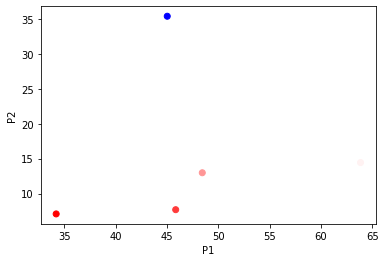

In [33]:
if __name__ == "__main__":

    execucoes = 5
    func = 99
    inicialStep = 0.0599
    finalStep = 0.0000001
    paramD = 0.2
    nfish = 30
    iterations = 50 #int(25000/nfish) <---- Isso é o que Hugo usava por conta da competição
    precisao = 1
    ajustePasso = 0
    arquivo = 'gerarVisualizacao_wfss/posicoes' + str(func) + '.txt'
    lower_limit_normative = [10.0,1.0] # [41.0,2.0]
    upper_limit_normative = [99.0,40.0] # [99.0,39.0] 
    lower_limit_expert = [20.0,3.0]  # [46.0,6.0]  
    upper_limit_expert = [45.0,7.0] # [88.0,35.0]
    lower_limit_theory = [15.0,2.0] # [45.0,5.0]
    upper_limit_theory = [60.0,10.0] # [89.0,36.0]
    limit_history = 5 # temporal knowledge
    constraints = [[0,">",1,1.0,2.0]]
    modo_temporal = 2
    
    
    with open(arquivo, 'w') as wrt:
    #func, inicialStep, finalStep, paramD, nfish, precisao, ajustePasso
        aux = main(func, inicialStep, finalStep,paramD, nfish, precisao, ajustePasso, iterations, lower_limit_normative, upper_limit_normative, lower_limit_expert, upper_limit_expert, lower_limit_theory, upper_limit_theory, limit_history, constraints, modo_temporal)
        wrt.write(str(aux) + "\n")
                

In [ ]:
# SOM para mapeamento - Não precisa rodar, só teste

# Colocar aqui a lista que sai após o numéro de iterações
data_list = [[66.71800710995181, 12.561439957142806], [70.20196150609137, 15.258861335820255], [43.979657760160215, 12.233567651595411], [70.07186065175597, 13.664579085884576], [64.2469067122897, 13.852159734805216], [61.75557201390171, 24.35717296713464], [61.98977703437205, 9.458186849343917], [65.22826838963239, 18.834026938311123], [52.243361143676985, 9.1243461120349], [46.223484782038945, 13.828099570753306], [47.49254706731054, 17.052699464086334], [92.99967180528114, 24.270106324365262], [53.58556713201765, 24.801697912292806], [55.19026268018424, 20.91181369514432], [71.93373830516178, 10.316825595125785], [52.10294426446103, 9.490329031141307], [66.25378872057888, 7.8242779506765965], [48.636561825650936, 18.03166626794412], [61.71848511248217, 23.09340683428998], [59.29413517733976, 18.872513301980067], [56.02592267284572, 15.578410065326281], [55.66243572390417, 24.615879955725667], [51.99746844743241, 17.04729691478688], [66.91146341162322, 16.456861305101956], [52.636264071099795, 23.69786118735948], [70.91406784117298, 20.141749261899857], [48.56722223685276, 19.76771670194521], [47.29650953069288, 17.16210220279432], [57.72301594503081, 20.959582698204237], [66.94307266112831, 6.891316736794066], [61.134257936142824, 24.41662866605561], [70.08175082729213, 21.05969128534211], [55.10350570222538, 23.12491707318893], [45.266780574180295, 15.23800727478671], [68.92404847817224, 16.135723541396683], [61.222036049097476, 8.602842017979045], [50.95968626934816, 16.232682349917592], [61.27232569588852, 22.880817575969687], [51.61005308947079, 2.21348732499495], [58.063537627561665, 20.622407595837334], [69.30091206199123, 15.800124745056308], [45.805404653849536, 16.719436648854572], [54.18239534560249, 18.42516453115812], [60.58607431654462, 12.553356219351702], [43.7779677818989, 14.976295347166547], [59.38440521743616, 15.716863032737635], [55.683145281687395, 12.848892053238139], [45.17690803349183, 17.55589130819391], [57.7845806167625, 22.149496782174122], [70.57706284217625, 21.34736845210417]]

In [ ]:
import pandas as pd
df_data = pd.DataFrame(data_list)


data = df_data.to_numpy().astype(float)

som_size = round(pow(5*nfish, 0.54321)) # essa é uma fórmula empírica para calcular um possível bom tamanho
som_shape = (som_size, som_size)

print(f'Tamanho da SOM: {som_size}x{som_size}')
# Para ver mais parámetros da biblioteca https://susi.readthedocs.io/en/latest/SOMClustering.html
som = susi.SOMClustering(n_rows = som_shape[0], n_columns=som_shape[1], random_state=1, learning_rate_start = 2.0,
                         n_iter_unsupervised = 75000)
som.fit(data) # Treina a rede

print("SOM Treinada!")

#Gerando gráfico da SOM
# Note que no scatter plot a primeira coordenada vai para Y e a segunda vai para X
clusters = som.get_clusters(data)
clusters_t = np.array(clusters).T
cluster_index = np.ravel_multi_index(clusters_t, som_shape)

print(f'{len(np.unique(cluster_index))} clusters mapeados!')

for c in np.unique(cluster_index):
    df_data.at[cluster_index == c, 'id_agrupamento'] = str(c)

# Note que a primeira coordenada vai para Y e a segunda vai para X
plt.scatter(x=[c[1] for c in clusters], y=[c[0] for c in clusters], c=cluster_index, alpha=0.9)
plt.gca().invert_yaxis()
plt.show()